# Inventors curriculum
Here is a notebook that generates the data for the FA2020 Inventors classes

* First have them build a model that predicts formation from one log - Learning goal: model interpretation
    * Need: One log with formations -DONE
* Then have them build a web app that takes logs and predicts formations from them - Learning goal: deploying online
    * Need: nothing but the one log
* Then have them build a model on all the well logs and deploy it - Learning goal: generalizing models
    * Need: All the logs with formations
* Next have them read in seismic data and compare to original data - Learning goal: trust but verify
    * Need: Seismic data and processed data from a pipeline
* Next have them predict where to drill next from production and log data - Learning goal: data viz
    * Need: Production, completions and log data
* Then have them build a widget from their drill data- Learning goal: interactivity
    * Need: Nothing but the above data 

### Part 1: Predict formation from one log

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import lasio

%matplotlib inline

In [2]:
PATH = "C:/Users/jrp4932/Downloads/rmotc/DataSets/Well Log/CD Files/LAS_log_files/"

In [3]:
well_log = lasio.read(PATH + "2524001C.las")

In [15]:
df0 = well_log.df()
df = df0.reset_index()
df["FORM"] = np.nan

#add formations to the dataframe
tops = {
    "SHNNu": 801,
    "SHNNl": 878,
    "NBRR": 2322,
    "F1WC": 3031,
    "MDDY": 4222,
    "DKOT": 4371,
    "LKOT": 4423,
    "MRNS": 4448,
}

for top, depth in tops.items():
    depth = depth
    df.iloc[df[df.DEPT > depth].index.values, -1] = top
df.dropna(inplace=True)
df.to_csv(r'well_data_Fa2020.csv')

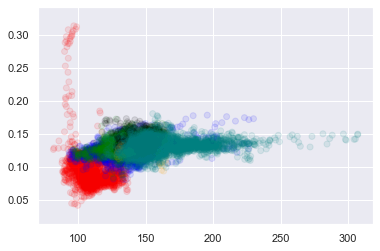

In [9]:
import seaborn as sns

sns.set()
colors = {
    "SHNNl": "red",
    "NBRR": "blue",
    "F1WC": "green",
    "MDDY": "black",
    "DKOT": "orange",
    "LKOT": "purple",
    "MRNS": "teal",
}
plt.scatter(df.GRGM, df.DPOR, c=df.FORM.apply(lambda x: colors[x]), alpha=0.1)

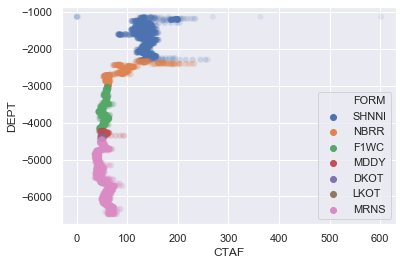

In [10]:
sns.scatterplot(df.CTAF, df.DEPT * -1, hue=df.FORM, alpha=0.1, linewidth=0)

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [12]:
le = LabelEncoder()
Y = le.fit_transform(df.FORM)
X = df.drop("FORM", axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=19
)

In [13]:
clf = SVC(gamma="scale", kernel="rbf")
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [14]:
clf.score(X_test, y_test)

0.9757462686567164

### Part 2: Deploying a web app

Text(0, 0.5, 'Depth')

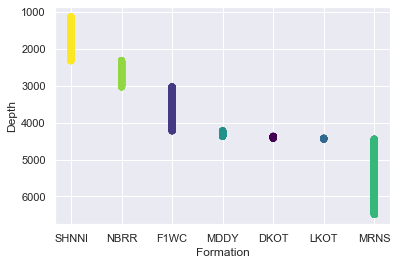

In [50]:
fig, ax = plt.subplots()
plt.scatter(le.inverse_transform(Y), df.DEPT, c=Y, cmap='viridis')
ax.invert_yaxis()
plt.xlabel('Formation')
plt.ylabel('Depth')

In [31]:
pickle.dump(clf, open('model.pkl','wb'))
output = open('label_encoder.pkl', 'wb')
pickle.dump(le, output)
output.close()

In [19]:
model = pickle.load(open('model.pkl','rb'))
print(model.predict(X_test))

[6 6 1 ... 3 6 4]


In [20]:
import numpy as np
from flask import Flask, request, jsonify
import pickle

In [21]:
app = Flask(__name__)
model = pickle.load(open('model.pkl','rb'))

In [23]:
@app.route('/api',methods=['POST'])
def predict():
    data = request.get_json(force=True)
    prediction = model.predict([[np.array(data['exp'])]])
    output = prediction[0]
    return jsonify(output)

In [25]:
app.run(port=5000, debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with stat


SystemExit: 1

C:\Users\jrp4932\AppData\Local\Continuum\anaconda3\envs\energyanalytics\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [26]:
%tb

SystemExit: 1

In [27]:
if __name__ == '__main__':
    app.run(port=5000, debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with stat


SystemExit: 1

In [29]:
import requests

url = 'http://localhost:5000/api'

r = requests.post(url,json={'exp':1.8,})
print(r.json())

ConnectionError: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000024E1C4B3860>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it',))